In [1]:
# Do we actually need all this using statements?
# we need ITensor as we use some functions direclty in the notebook, same for progressmeter
# Potentially, they are automatically included when loading RandomMeas ?
using Revise
using ITensors, ITensorMPS
using RandomMeas
using ProgressMeter # Shall we move it to some script file? The user does not need it explicitly?

## Shallow Shadows 

### Introduction
For a given ensemble of random unitaries $\{u\}$, the measurement or shadow channel $\mathcal{M}$ is defined as $\rho \rightarrow \mathcal{M}(\rho)=\mathbb{E}_u \left[  \sum_s \bra{s}\rho u^\dagger \ket{s}u^\dagger \ket{s}\bra{s}u\right]$ where $\mathbb{E}_u$ denotes the average over the random unitary ensemble. For certain ensembles, in particular local (single-qubit) and global (N-qubit) unitaries from unitary 2-designs, the channel and its inverse $\mathcal{M}^{-1}$ can be computed analytically (Huang et al., Nat. Phys. 2020). We can then use it to construct classical shadows for arbitrary input states $\rho$: $\hat{\rho}=\mathcal{M}^{-1}(u^\dagger \ket{s}\bra{s}u)$ where $s$ is the outcome bitstring  of a single computational basis measurement performed on $u\rho u^\dagger$.

For more general ensembles of random unitaries, we need to learn the channel $\mathcal{M}$, then invert it to form shadows and obtain a randomized measurement protocol.

This notebook illustrates this for case of random unitaries formed by shallow random quantum circuits [Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027), [Akhtar et al., Quantum 7, 1026 (2023)](https://quantum-journal.org/papers/q-2023-06-01-1026), [Bertoni et al, arxiv:2209.12924](https://arxiv.org/abs/2209.12924) and [Hu et al., arXiv:2402.17911](https://arxiv.org/abs/2402.17911). Importantly, we use the property that shallow random quantum circuits are locally scrambling circuits. This allows us to learn a representation of the channel from evaluating its action on single initial product state  [Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027).

### Learning depolarization vectors
In Ref. [Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027), it has been shown that with locally scrambling unitaries 
$$\mathcal{M}(\rho)=\sum_v c_v (\rho_{A(v)}\otimes 1_{B(v)}/2^{|B(v)|})$$
where we sum over all $2^N$ bitstrings $v=(v_1,v_2,\dots,v_N)$, and $A(v)=\{i| v_i=0\}$, and $B(v)=\{i|v_i=1\}$ denote the set of indices $i$ where $v_i$ is $0$ and $1$, respectively.
Thus, the "depolarization vector" $\vec{c} = (c_1,\dots,c_{2^N})$ fully specifies the channel $\mathcal{M}(\cdot)$.

Let us consider an initial state $\rho_0=\ket{0}\bra{0}$. We have the equality 
$$c_v=\mathrm{tr}(\mathcal{M}(\rho_0)O_v)$$
with $O_v=\bigotimes_{i}\left((\ket{0}\bra{0}-\ket{1}\bra{1})\delta_{v=1}+2(\ket{1}\bra{1})\delta_{v=0}\right)$. Therefore, the action of the channel $\mathcal{M}(\cdot)$ on the single initial state $\rho_0=\ket{0}\bra{0}$ fully specifies the vector $c_v$ and, hence, the channel $\mathcal{M}(\cdot)$.

To learn the vector $\vec{c}$, first we recall that 
$$\mathcal{M}(\rho_0)=\mathbb{E}_U\left[\sum_s \braket{s|U\rho_0U^\dag|s} U^\dag \ket{s}\bra{s} U \right].$$
 
Therefore, $c_v=\mathbb{E}_U[c_v(U)]$, with 
$$c_v(U)=\sum_s \braket{s|U\rho_0U^\dag|s} \braket{s|U O_v U^\dag|s}.$$

For a set of random unitaries $U$, these depolarization vectors $\vec{c}(U)=(c_1(U), \dots, c_{2^N}(U))$ can be computed as Matrix-Product-States (MPS) by evolving $\rho_0$ and $O_v$, using ITensor's internal routine [apply](https://itensor.github.io/ITensors.jl/dev/tutorials/MPSTimeEvolution.html),  and contracting the physical indices $s$. For instance, with a random circuit of depth 2, this is done as follows

In [2]:
Nu = 2000 # Number of unitaries
N = 8
ξ = siteinds("Qubit", N;addtags="output")

random_unitaries = Vector{Vector{ITensor}}()
depth = 2
for r in 1:Nu # For each unitary u, we generate a random circuit of depth 2
    push!(random_unitaries,random_circuit(ξ,depth)) 
end
cu = get_depolarization_vectors(random_unitaries,ξ); # For all NU unitaries, we get the individual depolarization vectors, stored as vector of vectors of length NU


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


### Fitting the average depolarization vector as an MPS

We now compute an matrix product state (MPS) approximation $\vec{c}$ of the average depolarization vector $ 1/{N_u}\sum_U c_v(U)$. To efficiently obtain such MPS approximation without actually computing the direct average $ 1/{N_u}\sum_U c_v(U)$ as a dense vector, we adapt a fitting algorithm presented in [T Baumgratz et al 2013 New J. Phys. 15 125004](https://iopscience.iop.org/article/10.1088/1367-2630/15/12/125004): We minimize the cost function $\vec{c}=\argmin_{\vec{x}}\mathcal{C}(\vec{x})$ with $$ \mathcal{C}(\vec{x}) =||\vec{x}-1/N_U\sum_U \vec{c}(U)||^2_2-||1/N_U\sum_U \vec{c}(U)||^2_2.$$ We note that the second term is constant (does not depend on $\vec{x}$) and has been added in order to facilitate the cost function evaluation (runtime $O(N_u)$ instead of $O(N_u^2)$). The compression algorithm updates each tensor sequentially over a finite number of sweeps.

In [3]:
nsweeps = 6 # Number of sweeps for the fitting 
χ = 4 # We minimize the cost function C in the space of MPS with the bond dimension χ.
c = fit_depolarization_vector(cu,χ,nsweeps); # approximate the depolarization vector by an MPS of bond dimension χ

Cost function -0.009947784765959285
Cost function -0.41359657164395053


Progress:  33%|█████████████▋                           |  ETA: 0:00:07

Cost function -0.4135994920702601


Progress:  50%|████████████████████▌                    |  ETA: 0:00:05

Cost function -0.4135995990343659
Cost function -0.4135996154723972


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:01

Cost function -0.4135996210819028


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


Cost function -0.41359962393881616


### Inverting the channel

For local invariant unitaries, the inverse channel has the following form ([Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027)):
$$\mathcal{M}^{-1}(\sigma)=\sum_v d_v (\sigma_{A(v)}\otimes 1_{B(v)}/{2^{|B(v)|}})$$
with $\vec{d} = (d_1,\dots,d_{2^N})$.

Thus, we want to find a vector $\vec{d}$ such that, for all $\rho$, 
$$[\mathcal{M}^{-1}\circ\mathcal{M}](\rho)=\sum_{v,v'}c_vd_{v'} (\sigma_{A(v)}\otimes 1_{B(v)}/{2^{B(v)}})_{A(v')}\otimes 1_{B(v')}/{2^{B(v')}}=\sum_{v,v'}c_vd_{v'}(\rho_{A(v)\cap A(v')}\otimes 1_{\bar{A(v)\cap A(v')}}/{2^{\bar{|A(v)\cup A(v')}|}})=\rho$$

Noting that $A(v)\cap A(v')=A(v||v')$ with $||$ is the bitwise or operation, we obtain the condition 
$$\sum_{v,v'}c_vd_{v'}(\rho_{A(v||v')}\otimes 1_{B(v||v')}/2^{|B(v||v')|})=\rho$$

This can be satisfied by minimizing the cost function

$$\mathcal{C}'(\vec{x})=||\sum_{v''}(\sum_{v,v'}c_v x_{v'}\delta_{v'',v||v'})-\delta_{v'',0}||^2$$

such that $\vec{d} = \argmin_{\vec{x}} \mathcal{C}'(\vec{x})$.

To do this efficiently, we parametrize $\vec{x}$ as an MPS with finite bond dimension $\chi$ and write $\mathcal{C}'(\vec{x})$ as a result of a tensor contraction, whose gradients with respects to the tensors of the MPS $\vec{x}$ can be evaluated by automatic differentations using the package Zygote. The algorithm proceeds by a sequence of sweeps, updating each local tensor sequentially. We obtain an MPS approximation to $\vec{d}$ with finite bond dimension $\chi$.

In [4]:
d = get_inverse_depolarization_vector(c,χ,nsweeps); # We minimize the cost function C' in the space of MPS with the bond dimension χ.

sweep 1 Cost function 0.2769638674401489
sweep 2 Cost function 0.10486644349372554
sweep 3 Cost function 0.0442220272046151
sweep 4 Cost function 0.031034219339772906
sweep 5 Cost function 0.027077996082274458
sweep 6 Cost function 0.025527094723710286


## Simulated experiment
We are ready to perform an experiment on a unknown state $\ket{\psi}$, build shadows as MPO and estimate expectation values.

In [5]:
circuit = random_circuit(ξ,depth)
ψ0 = MPS(ξ,["Dn" for n in 1:N]  ) 
ψ = apply(circuit,ψ0); # We construct some random pure state ψ, our simulated experimental (unknown) state

We perform randomized measurements in a simulated quantum device.

In [6]:
NM = 100
measurement_data = Array{Int,3}(undef,Nu,NM,N)
@showprogress dt=1 for r in 1:Nu
    measurement_data[r,:,:] = get_RandomMeas(ψ,random_unitaries[r],NM,"dense") #data acquisition in simulated quantum device
end

UndefVarError: UndefVarError: `get_RandomMeas` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

We aim to estimate XX correlations. We construct the corresponding MPOs and compute the exact expectation values.

In [7]:
O = Vector{MPO}()
for i in 1:N-1
    ampo = AutoMPO()
    ampo .+= "X", i,"X",i+1
    push!(O,MPO(ampo,ξ))
end

O_exact = Vector{Float64}()
for o in O
    push!(O_exact,real(inner(ψ',o,ψ)))
end

For a given unitary, we know that the correspond shadow estimator for an observable $O$ can be written as 
$$O_e = \sum_s P_U(s) \mathrm{tr}(\mathcal{M}^{-1}(U^\dag\ket{s}\bra{s}U) O)=\sum_s P_U(s) \braket{s|U\mathcal{M}^{-1}(O)U^\dag|s}$$
where $P_U(s)$ is the estimated Born probability, and we have used the fact that $\mathcal{M}^{-1}$ is self-adjoint. This is implemented as follows:

In [8]:
O_est = zeros(Float64,N-1);
@showprogress dt=1 for i in 1:N-1
    Q = apply_inverse_channel(O[i],d) #we calculate Q=M^-1(O)
    for r in 1:Nu
        Qu = apply(random_unitaries[r],Q;apply_dag=true)#we calculate UQU^dag 
        Qu_s = get_Born(Qu) #we calculate <s|UQU^dag|s> 
        P = get_Born(measurement_data[r,:,:],ξ) 
        O_est[i] += real((P*Qu_s)[])/Nu
    end
end
@show O_est

BoundsError: BoundsError: attempt to access 2×2×2×2×2×2×2×2 Array{Int64, 8} at index [0, 0, 0, 0, 0, 0, 0, 0]

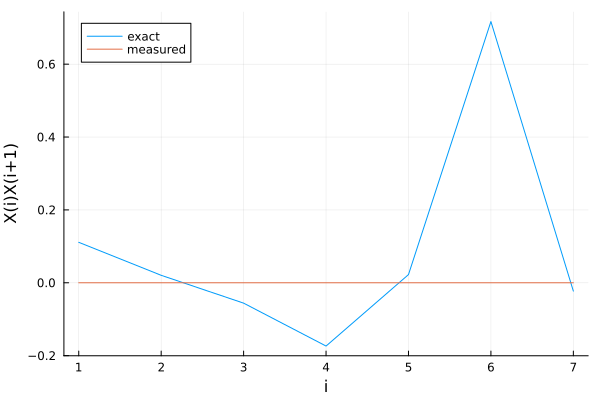

In [9]:
using Plots
plot(O_exact,label="exact")
plot!(O_est,label="measured")

xlabel!("i")
ylabel!("X(i)X(i+1)")